# 3. Analyse des clients

Comprendre quels clients tirent la croissance et comment mobiliser les autres.

## Importation des bibliothèques

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Charte graphique

In [45]:
# Couleurs principales
MINI_BLUE = '#607D8B'    
MINI_GREEN = '#A5D6A7'   
MINI_GRAY = '#9E9E9E'    

MANDARINE = '#FF9800'    
SOFT_ORANGE = '#FFC107'  
BLEU_CANARD = '#00796B'     
WINE = '#880E4F'  

# fond et lignes de structure
LIGHT_GRID = '#EDEDED' 
BG_WHITE = '#FFFFFF'     
LIGHT_GRAY = '#BDBDBD'

def set_minimalist_style():
    """Applique le style graphique 'Minimaliste 2025' pour la clarté."""
    
    # 1. Utiliser le thème 'white' de Seaborn
    sns.set_theme(style="white") 
    
    # Définir la nouvelle séquence de couleurs complète (7 couleurs)
    FULL_COLOR_CYCLE = [
        MINI_BLUE,
        MINI_GREEN,
        MINI_GRAY,
        MANDARINE, 
        SOFT_ORANGE, 
        BLEU_CANARD,
        WINE
    ]
    
    # 2. Modifier les paramètres globaux (rcParams)
    plt.rcParams.update({
        
        # --- FOND ET CADRE ---
        'figure.facecolor': BG_WHITE,
        'axes.facecolor': BG_WHITE,
        'axes.edgecolor': LIGHT_GRAY, 
        'axes.linewidth': 0.5,
        
        # --- GRILLE ---
        'axes.grid': True,
        'grid.color': LIGHT_GRID,
        'grid.linestyle': '-',
        'grid.linewidth': 0.7,
        
        # --- TYPOGRAPHIE ET LABELS ---
        'font.family': 'sans-serif',
        'axes.titlesize': 18,
        'axes.labelsize': 11,
        'legend.frameon': False,
        
        # --- LIGNES ET PALETTE ---
        'lines.linewidth': 1.8,
        # Définition du cycle de 7 couleurs pour Matplotlib
        'axes.prop_cycle': plt.cycler('color', FULL_COLOR_CYCLE) 
    })
    
    # 3. Appliquer également la palette de 7 couleurs à Seaborn
    sns.set_palette(FULL_COLOR_CYCLE)

set_minimalist_style()

## 3.a. Analyse des score Recency-Frequency

### Importation des données

In [57]:
df_rf = pd.read_csv(r"../1.Donnees\3.Exports_csv\2.analyse_clients\2.1.segments_clients\2.1.1.score_RF_groupe.csv").copy()
df_rf

,nombre_clients,score_recency,score_frequency
0,2812,4,4
1,1503,4,3
2,1321,4,2
3,1217,4,1
4,2127,3,4
5,1660,3,3
6,1597,3,2
7,1469,3,1
8,1373,2,4
9,1821,2,3


### Préparation des données

In [47]:
# Création du tableau croisé dynamique contenant la matrice des clients segmentés par Récence x Fréquence :
rf_pivot = df_rf.pivot_table(values = 'nombre_clients', index = 'score_recency', columns ='score_frequency', aggfunc = 'sum').fillna(value = 0).astype('int64')
rf_pivot

score_frequency,1,2,3,4
score_recency,,,,
1,2318,2126,1869,541
2,1850,1809,1821,1373
3,1469,1597,1660,2127
4,1217,1321,1503,2812


### Visualisation

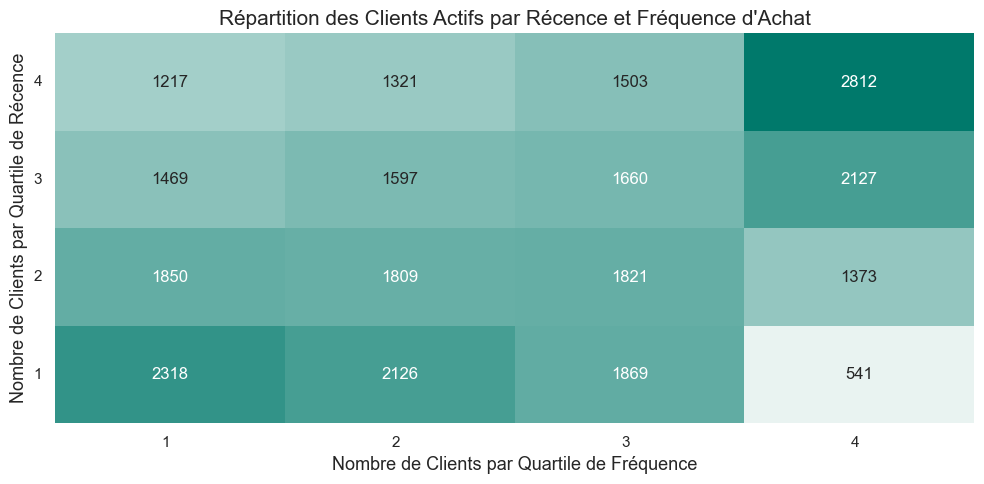

In [48]:
from typing import List

# --- Configuration de la Palette de Couleurs ---
# Création d'une palette de couleurs dégradées (Heatmap) basée sur une couleur principale ('BLEU_CANARD').
# Cette palette visuelle est utilisée pour représenter l'intensité (la concentration des clients).
cmap_bleu_canard = sns.light_palette(BLEU_CANARD, as_cmap=True)

# --- Initialisation de la Figure et du Tracé ---
fig, ax = plt.subplots(figsize=(10, 5))

# --- Tracé de la Heatmap ---
sns.heatmap(
    rf_pivot, # Le DataFrame 'rf_pivot' contient la matrice des clients segmentés par Récence x Fréquence.
    ax=ax,
    annot=True, # Afficher les annotations numériques (le nombre de clients) dans chaque cellule.
    fmt='0.0f', # Formatage des annotations en nombres entiers sans décimale.
    cmap=cmap_bleu_canard, # Application de la palette de couleurs dégradées définie.
    cbar=False, # Suppression de la barre de couleur (légende de l'échelle) pour simplifier la lecture, 
                # car les annotations suffisent pour comprendre la densité.
    vmax=rf_pivot.values.max() # Définition de la valeur maximale de l'échelle de couleur 
                               # pour une saturation optimale.
)

# --- Mise en Forme et Lisibilité ---
# Inversion de l'axe Y pour aligner la meilleure Récence (quartile 4) en haut du graphique, 
ax.invert_yaxis()
ax.set_title("Répartition des Clients Actifs par Récence et Fréquence d'Achat", fontsize=15)
ax.set_xlabel("Nombre de Clients par Quartile de Fréquence", fontsize=13)
ax.set_ylabel("Nombre de Clients par Quartile de Récence", fontsize=13)

# Configuration de l'orientation des ticks pour maximiser la clarté.
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)

# Ajustement automatique des marges pour éviter le chevauchement des étiquettes et du titre.
plt.tight_layout()

plt.show()

## 3.b. Panier moyen global

### Importation des données

In [58]:
df_panier_moyen_global = pd.read_csv(r"../1.Donnees\3.Exports_csv\2.analyse_clients\2.1.segments_clients\2.1.2.nombe_client_par_paniers_moyens_paliers_business.csv").copy()
df_panier_moyen_global

,nombre_clients,commandes
0,22587,Pas de commande
1,17703,Commande moyenne (40-60€)
2,5279,Commande importante (60-200€)
3,3686,Petite commande (<20€)
4,631,Commande très importante (200-500€)
5,114,Commande exceptionnelle (>500€)


### Préparation des données

In [50]:
# --- Définition du Dictionnaire de Reclassification ---

# Transformation des étiquettes descriptives originales en étiquettes numériques simplifiées,
# essentiel pour standardiser les libellés de plage de montant pour la visualisation.
mapping_montant = {
    'Pas de commande': '0€', 
    'Petite commande (<20€)': '<20€',
    'Commande moyenne (40-60€)': '40-60€',
    'Commande importante (60-200€)': '60-200€', 
    'Commande très importante (200-500€)': '200-500€',
    'Commande exceptionnelle (>500€)': '>500€'
}

# Application du dictionnaire de mapping à la colonne 'commandes'.
# Le remplacement des valeurs permet la transition vers une classification simplifiée.
df_panier_moyen_global['montant_simple'] = df_panier_moyen_global['commandes'].replace(mapping_montant)

# --- Définition de l'Ordre Catégoriel ---

# Liste des catégories dans l'ordre croissant des montants.
ordre_commandes = [
    '0€', 
    '<20€',
    '40-60€',
    '60-200€', 
    '200-500€',
    '>500€'
]

# Conversion de la colonne 'montant_simple' en type Catégoriel Pandas.
df_panier_moyen_global['montant_simple'] = pd.Categorical(df_panier_moyen_global['montant_simple'], categories=ordre_commandes, ordered=True)

# Application du tri du DataFrame selon l'ordre logique défini par le type 'Categorical'.
df_panier_moyen_global = df_panier_moyen_global.sort_values('montant_simple')

# Définition de la colonne triée comme nouvel index du DataFrame.
df_panier_moyen_global.set_index('montant_simple', inplace=True)

# Affichage de l'index pour vérification de l'ordre catégoriel appliqué.
df_panier_moyen_global.index

CategoricalIndex(['0€', '<20€', '40-60€', '60-200€', '200-500€', '>500€'], categories=['0€', '<20€', '40-60€', '60-200€', '200-500€', '>500€'], ordered=True, dtype='category', name='montant_simple')

### Visualisation

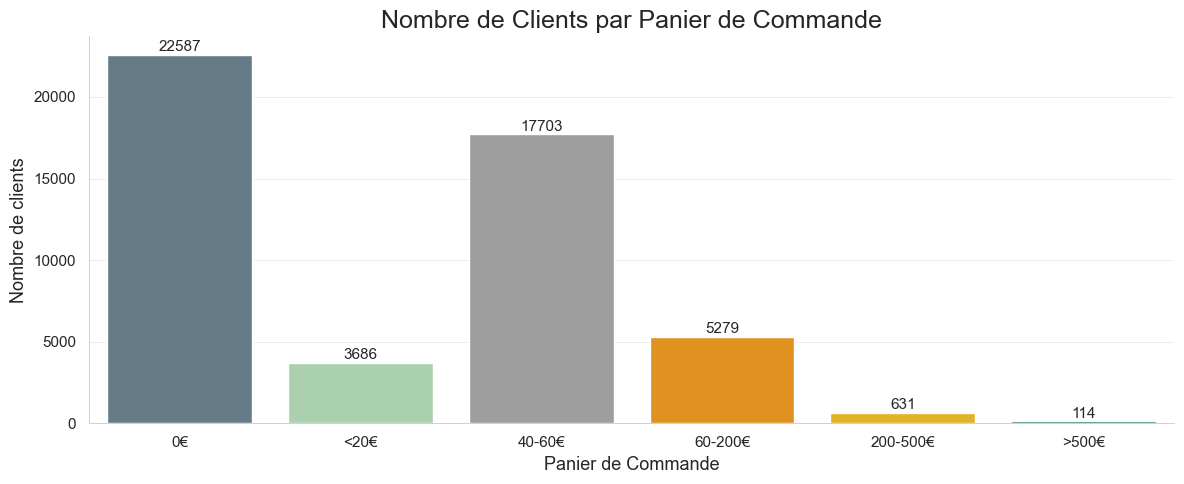

In [51]:
# --- Initialisation de la Figure ---
fig, ax = plt.subplots(figsize=(12, 5))

# --- Définition et Application de la Palette de Couleurs ---
# Définition d'une palette de couleurs personnalisée.
PALETTE_PANIER = {
    '0€' : '#607D8B', 
    '<20€' : '#A5D6A7', 
    '40-60€' : '#9E9E9E', 
    '60-200€' : '#FF9800', 
    '200-500€' : '#FFC107', 
    '>500€' : '#00796B' 
}

# --- Tracé du Graphique en Barres (Barplot) ---
# Utilisation de Seaborn pour générer le graphique. Les données sont triées par l'index 'montant_simple'.
sns.barplot(
    data= df_panier_moyen_global,
    x='montant_simple', 
    y='nombre_clients', 
    palette=PALETTE_PANIER,
    hue='montant_simple', # Applique la palette aux barres individuelles.
    ax=ax
)

# --- Ajout des Étiquettes de Valeur ---
# Ajout des valeurs exactes au-dessus de chaque barre pour une lecture précise des effectifs.
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, # Position X centrée sur la barre.
            height + 50,                       # Position Y légèrement au-dessus de la barre (ajustement de +50).
            f'{height:.0f}',                   # Formatage en nombre entier (sans décimale).
            ha='center', 
            va='bottom', 
            fontsize=11 
        )


# --- Configuration des Titres et Axes ---
ax.set_title('Nombre de Clients par Panier de Commande')

ax.set_xlabel('Panier de Commande', fontsize=13)

# Définition explicite des positions des ticks pour garantir l'alignement des étiquettes X.
ax.set_xticks(range(len(df_panier_moyen_global.index)))
# Application des noms des catégories (montant_simple) et rotation à zéro.
ax.set_xticklabels(df_panier_moyen_global.index, rotation=0, ha='center')
ax.set_ylabel('Nombre de clients', fontsize=13)

# Retrait des bordures supérieures et droite du graphique (style Seaborn/Minimaliste).
sns.despine()
# Ajustement des marges pour un rendu propre.
fig.tight_layout()

plt.show()

Panier moyen global = 53€

Accessoires = 99,2% des ventes

45% des clients n'ont pas effectué d'achat

## 3.c. Panier moyen selon la catégorie

### Importation des données

In [59]:
df_panier_moyen = pd.read_csv(r"../1.Donnees\3.Exports_csv\1.analyse_descriptive\1.1.vue_globale_3ans\1.1.2.top_categories_en_volume.csv").copy()

df_panier_moyen_fideles = pd.read_csv(r"../1.Donnees\3.Exports_csv\2.analyse_clients\2.2.clients_fideles\2.2.nombre_achats_clients_fideles_categorie.csv").copy()

df_panier_moyen_nouveaux = pd.read_csv(r"../1.Donnees\3.Exports_csv\2.analyse_clients\2.3.nouveaux_clients\2.3.produits_entree.csv").copy()

df_panier_moyen_risque = pd.read_csv(r"../1.Donnees\3.Exports_csv\2.analyse_clients\2.4.clients_a_risque\2.4.analyse_panier_precedent.csv").copy() 

### Préparation des données

In [60]:
# On conserve uniquement la catégorie et le volume vendu :
df_panier_moyen.drop(columns=['ca_total','marge_totale', 'marge_pct'], inplace= True)

In [61]:
# Définition des index sur "categorie" :

df_panier_moyen.set_index('categorie', inplace = True)
df_panier_moyen_fideles.set_index('categorie', inplace = True)
df_panier_moyen_nouveaux.set_index('categorie', inplace = True)
df_panier_moyen_risque.set_index('categorie', inplace = True)

In [62]:
# L'obectif est de calculer les volumes vendus en % du total vendu pour chaque segment de client :

# Panier moyen global:

df_panier_moyen['volume_total'] = df_panier_moyen['volume_total']/(df_panier_moyen['volume_total'].sum())


# Panier moyen fideles : 

df_panier_moyen_fideles['nb_achats_champions'] = df_panier_moyen_fideles['nb_achats_champions'] /(df_panier_moyen_fideles['nb_achats_champions'].sum())


# Panier moyen nouveaux : 

df_panier_moyen_nouveaux['nombre_premier_achat'] = df_panier_moyen_nouveaux['nombre_premier_achat'] / (df_panier_moyen_nouveaux['nombre_premier_achat'].sum())

# Panier moyen a risque : 

df_panier_moyen_risque['nb_achats_champions_hibernants'] = df_panier_moyen_risque['nb_achats_champions_hibernants'] / (df_panier_moyen_risque['nb_achats_champions_hibernants'].sum())

### Visualisation

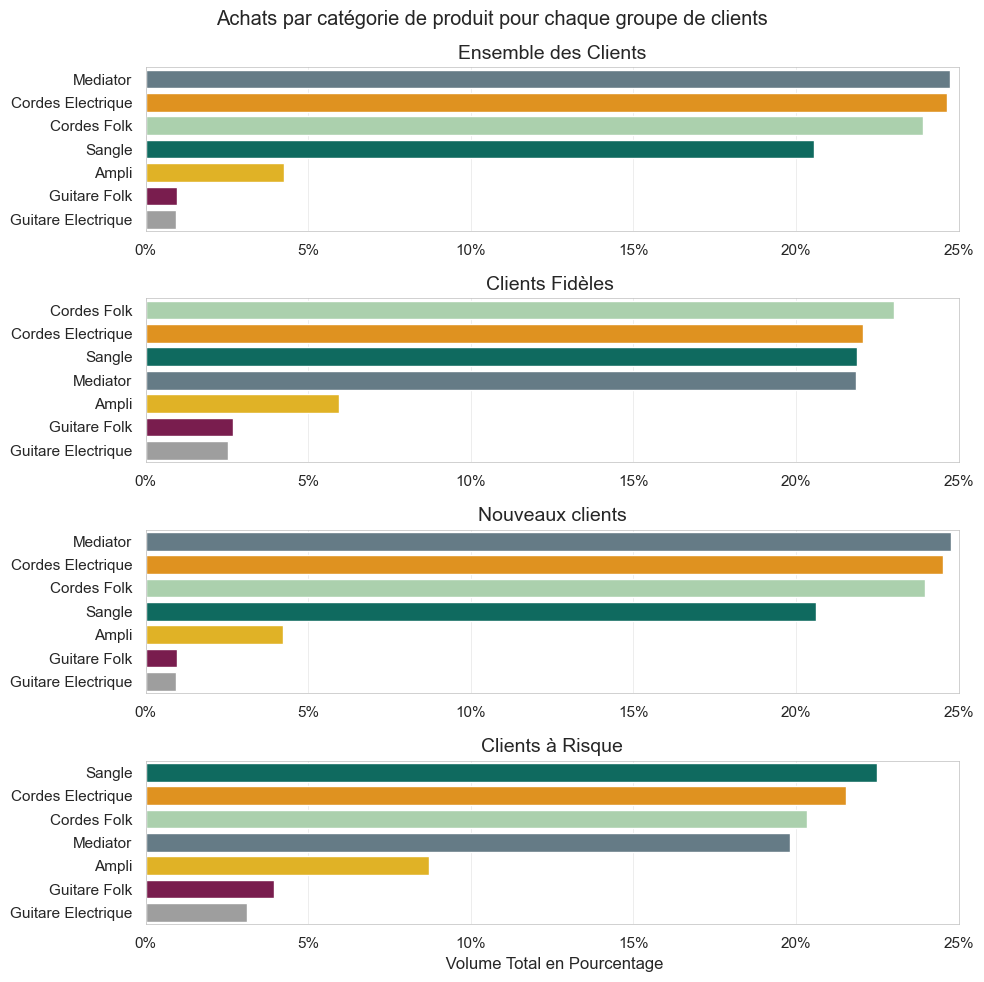

In [63]:
fig, ax = plt.subplots(nrows = 4, ncols= 1, figsize = (10,10))

PALETTE_PANIER = {
    'Mediator' : '#607D8B', 
    'Ampli' :  '#FFC107', 
    'Sangle' :   '#00796B', 
    'Cordes Electrique' : '#FF9800', 
    'Cordes Folk' : '#A5D6A7' , 
    'Guitare Electrique' : '#9E9E9E', 
    'Guitare Folk' : '#880E4F'
}

# GRAPHE 1 : Panier moyen global 

sns.barplot(data= df_panier_moyen, x='volume_total', y=df_panier_moyen.index, ax=ax[0], hue= 'categorie', palette = PALETTE_PANIER, legend=False) 
ax[0].set_title('Ensemble des Clients', fontsize = 14)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i:  f'{(x*100):.0f}%'))
ax[0].set_xlim(0,0.25)

# GRAPHE 2 : Panier moyen clients fidèles

sns.barplot(data= df_panier_moyen_fideles, x='nb_achats_champions', y=df_panier_moyen_fideles.index, ax=ax[1], hue= 'categorie', palette = PALETTE_PANIER, legend=False) 
ax[1].set_title('Clients Fidèles ', fontsize = 14)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i:  f'{(x*100):.0f}%'))
ax[1].set_xlim(0,0.25)

# GRAPHE 3 : Panier moyen nouveaux clients

sns.barplot(data= df_panier_moyen_nouveaux, x='nombre_premier_achat', y=df_panier_moyen_nouveaux.index, ax=ax[2], hue= 'categorie', palette = PALETTE_PANIER, legend=False) 
ax[2].set_title('Nouveaux clients', fontsize = 14)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i:  f'{(x*100):.0f}%'))
ax[2].set_xlim(0,0.25)

# GRAPHE 4 : Panier moyen clients à risque

sns.barplot(data= df_panier_moyen_risque, x='nb_achats_champions_hibernants', y=df_panier_moyen_risque.index, ax=ax[3], hue= 'categorie', palette = PALETTE_PANIER, legend=False) 
ax[3].set_title('Clients à Risque', fontsize = 14)
ax[3].set_ylabel('')
ax[3].set_xlabel(' Volume Total en Pourcentage', fontsize = 12)
ax[3].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i:  f'{(x*100):.0f}%'))
ax[3].set_xlim(0,0.25)

plt.suptitle("Achats par catégorie de produit pour chaque groupe de clients", )
plt.tight_layout()
plt.show()